In [1]:
!pip install timm

In [2]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
class_names=sorted(os.listdir('/kaggle/input/cifar10-pngs-in-folders/cifar10/train'))
print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))  

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


In [5]:
path_label0=[]
for dirname, _, filenames in os.walk('/kaggle/input/cifar10-pngs-in-folders/cifar10/train'):
    for filename in filenames:
        if filename[-4:]=='.png':
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            path_label0+=[(path,normal_mapping[label])]
        
tpath_label0=[]
for dirname, _, filenames in os.walk('/kaggle/input/cifar10-pngs-in-folders/cifar10/test'):
    for filename in filenames:
        if filename[-4:]=='.png':
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            tpath_label0+=[(path,normal_mapping[label])]
    
# path_label = random.sample(path_label0, 2000)  
# tpath_label = random.sample(tpath_label0, 400) 

In [6]:
path_label = path_label0
tpath_label = tpath_label0

In [7]:
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [8]:
trainset = ImageDataset(path_label, transform)
testset = ImageDataset(tpath_label, transform)

In [9]:
labels = [label for _, label in trainset.path_label]

In [10]:
train_loader=DataLoader(trainset,batch_size=32,shuffle=True)
test_loader=DataLoader(testset,batch_size=32)

In [11]:
for images, labels in train_loader:
    break
im=make_grid(images,nrow=16)

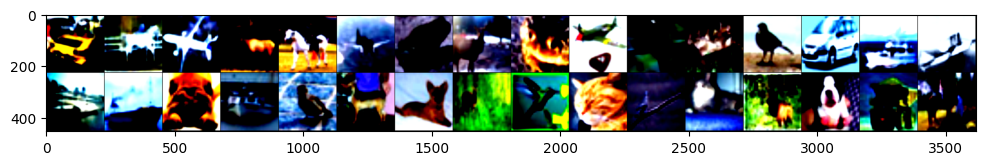

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

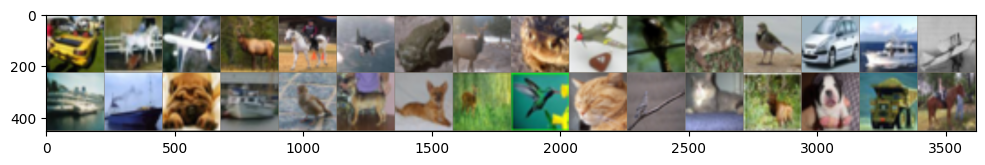

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [15]:
torch.manual_seed(42)

In [16]:
class MyModel(nn.Module):

    def __init__(self, model_name='mobilevit_s', pretrained=True):
        super(MyModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained, in_chans=3)
        self.fc1 = nn.Linear(1000,16)
        self.fc2 = nn.Linear(16,64)        
        self.fc3 = nn.Linear(64,len(class_names))
        
    def forward(self, x):
        #print(x.shape)
        x = self.model(x)
        #print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        #print(x.shape)
        return x

In [17]:
model = MyModel() 
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
# Define the scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

In [18]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to GPU
model.to(device)

MyModel(
  (model): ByobNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      

In [19]:
epochs=20

import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in tqdm(range(epochs)):
    scheduler.step()  # Step the scheduler
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1        
        # Move data to GPU
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred=model(X_train)
        loss=criterion(y_pred,y_train)
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss = loss.detach().cpu().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr.item())
                  
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1 
            # Move data to GPU
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val=model(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
    loss=criterion(y_val,y_test)
    loss = loss.detach().cpu().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr.item())
                  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')    

  0%|          | 0/20 [00:00<?, ?it/s]

epoch:  0  batch:  200 [  2000/8000]  loss: 0.62621915  accuracy: 220.600%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.40295240  accuracy: 243.150%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.18504828  accuracy: 253.933%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.24004269  accuracy: 259.337%
epoch:  0  batch: 1000 [ 10000/8000]  loss: 0.34808284  accuracy: 263.580%
epoch:  0  batch: 1200 [ 12000/8000]  loss: 0.56158882  accuracy: 266.375%
epoch:  0  batch: 1400 [ 14000/8000]  loss: 0.24394229  accuracy: 268.821%


  5%|▌         | 1/20 [09:21<2:57:43, 561.26s/it]

epoch:  1  batch:  200 [  2000/8000]  loss: 0.42883632  accuracy: 290.400%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.48629084  accuracy: 288.100%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.28129116  accuracy: 289.000%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.08361278  accuracy: 289.200%
epoch:  1  batch: 1000 [ 10000/8000]  loss: 0.10756935  accuracy: 289.410%
epoch:  1  batch: 1200 [ 12000/8000]  loss: 0.13479647  accuracy: 289.358%
epoch:  1  batch: 1400 [ 14000/8000]  loss: 0.14177947  accuracy: 289.393%


 10%|█         | 2/20 [14:19<2:01:56, 406.50s/it]

epoch:  2  batch:  200 [  2000/8000]  loss: 0.02882999  accuracy: 302.800%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.04020368  accuracy: 306.000%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.06351265  accuracy: 307.250%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.04289097  accuracy: 307.887%
epoch:  2  batch: 1000 [ 10000/8000]  loss: 0.07907972  accuracy: 308.410%
epoch:  2  batch: 1200 [ 12000/8000]  loss: 0.03617364  accuracy: 308.850%
epoch:  2  batch: 1400 [ 14000/8000]  loss: 0.04911788  accuracy: 309.214%


 15%|█▌        | 3/20 [19:18<1:41:15, 357.36s/it]

epoch:  3  batch:  200 [  2000/8000]  loss: 0.02823880  accuracy: 315.550%
epoch:  3  batch:  400 [  4000/8000]  loss: 0.17203811  accuracy: 315.425%
epoch:  3  batch:  600 [  6000/8000]  loss: 0.07108720  accuracy: 314.983%
epoch:  3  batch:  800 [  8000/8000]  loss: 0.00076506  accuracy: 314.975%
epoch:  3  batch: 1000 [ 10000/8000]  loss: 0.03985811  accuracy: 315.000%
epoch:  3  batch: 1200 [ 12000/8000]  loss: 0.00056312  accuracy: 314.925%
epoch:  3  batch: 1400 [ 14000/8000]  loss: 0.00180722  accuracy: 314.871%


 20%|██        | 4/20 [24:17<1:29:09, 334.33s/it]

epoch:  4  batch:  200 [  2000/8000]  loss: 0.02184573  accuracy: 317.050%
epoch:  4  batch:  400 [  4000/8000]  loss: 0.00522431  accuracy: 317.100%
epoch:  4  batch:  600 [  6000/8000]  loss: 0.05854505  accuracy: 316.850%
epoch:  4  batch:  800 [  8000/8000]  loss: 0.00116070  accuracy: 316.825%
epoch:  4  batch: 1000 [ 10000/8000]  loss: 0.00579191  accuracy: 316.760%
epoch:  4  batch: 1200 [ 12000/8000]  loss: 0.01597439  accuracy: 316.617%
epoch:  4  batch: 1400 [ 14000/8000]  loss: 0.03848791  accuracy: 316.593%


 25%|██▌       | 5/20 [29:17<1:20:28, 321.93s/it]

epoch:  5  batch:  200 [  2000/8000]  loss: 0.00559524  accuracy: 318.650%
epoch:  5  batch:  400 [  4000/8000]  loss: 0.00768318  accuracy: 318.325%
epoch:  5  batch:  600 [  6000/8000]  loss: 0.00041947  accuracy: 318.400%
epoch:  5  batch:  800 [  8000/8000]  loss: 0.01229160  accuracy: 318.450%
epoch:  5  batch: 1000 [ 10000/8000]  loss: 0.00146274  accuracy: 318.400%
epoch:  5  batch: 1200 [ 12000/8000]  loss: 0.00422965  accuracy: 318.425%
epoch:  5  batch: 1400 [ 14000/8000]  loss: 0.01139936  accuracy: 318.407%


 30%|███       | 6/20 [34:15<1:13:16, 314.03s/it]

epoch:  6  batch:  200 [  2000/8000]  loss: 0.00077988  accuracy: 318.850%
epoch:  6  batch:  400 [  4000/8000]  loss: 0.00043150  accuracy: 319.000%
epoch:  6  batch:  600 [  6000/8000]  loss: 0.01330214  accuracy: 318.967%
epoch:  6  batch:  800 [  8000/8000]  loss: 0.01598834  accuracy: 318.950%
epoch:  6  batch: 1000 [ 10000/8000]  loss: 0.02276981  accuracy: 318.950%
epoch:  6  batch: 1200 [ 12000/8000]  loss: 0.04472746  accuracy: 318.992%
epoch:  6  batch: 1400 [ 14000/8000]  loss: 0.00031276  accuracy: 319.007%


 35%|███▌      | 7/20 [39:14<1:06:56, 308.97s/it]

epoch:  7  batch:  200 [  2000/8000]  loss: 0.00321427  accuracy: 319.100%
epoch:  7  batch:  400 [  4000/8000]  loss: 0.01879231  accuracy: 319.175%
epoch:  7  batch:  600 [  6000/8000]  loss: 0.00308042  accuracy: 319.267%
epoch:  7  batch:  800 [  8000/8000]  loss: 0.00033522  accuracy: 319.288%
epoch:  7  batch: 1000 [ 10000/8000]  loss: 0.00197901  accuracy: 319.320%
epoch:  7  batch: 1200 [ 12000/8000]  loss: 0.00211839  accuracy: 319.283%
epoch:  7  batch: 1400 [ 14000/8000]  loss: 0.00456212  accuracy: 319.200%


 40%|████      | 8/20 [44:13<1:01:08, 305.69s/it]

epoch:  8  batch:  200 [  2000/8000]  loss: 0.00066362  accuracy: 319.200%
epoch:  8  batch:  400 [  4000/8000]  loss: 0.00038382  accuracy: 319.325%
epoch:  8  batch:  600 [  6000/8000]  loss: 0.00018317  accuracy: 319.433%
epoch:  8  batch:  800 [  8000/8000]  loss: 0.00757854  accuracy: 319.413%
epoch:  8  batch: 1000 [ 10000/8000]  loss: 0.00293843  accuracy: 319.420%
epoch:  8  batch: 1200 [ 12000/8000]  loss: 0.00734788  accuracy: 319.383%
epoch:  8  batch: 1400 [ 14000/8000]  loss: 0.00040337  accuracy: 319.400%


 45%|████▌     | 9/20 [49:12<55:39, 303.60s/it]  

epoch:  9  batch:  200 [  2000/8000]  loss: 0.00256648  accuracy: 319.400%
epoch:  9  batch:  400 [  4000/8000]  loss: 0.00084855  accuracy: 319.325%
epoch:  9  batch:  600 [  6000/8000]  loss: 0.00066818  accuracy: 319.333%
epoch:  9  batch:  800 [  8000/8000]  loss: 0.00041784  accuracy: 319.375%
epoch:  9  batch: 1000 [ 10000/8000]  loss: 0.00055550  accuracy: 319.400%
epoch:  9  batch: 1200 [ 12000/8000]  loss: 0.00568204  accuracy: 319.442%
epoch:  9  batch: 1400 [ 14000/8000]  loss: 0.01203581  accuracy: 319.386%


 50%|█████     | 10/20 [54:10<50:21, 302.11s/it]

epoch: 10  batch:  200 [  2000/8000]  loss: 0.05311563  accuracy: 319.300%
epoch: 10  batch:  400 [  4000/8000]  loss: 0.00045440  accuracy: 319.125%
epoch: 10  batch:  600 [  6000/8000]  loss: 0.00034344  accuracy: 319.233%
epoch: 10  batch:  800 [  8000/8000]  loss: 0.04018494  accuracy: 319.288%
epoch: 10  batch: 1000 [ 10000/8000]  loss: 0.00110786  accuracy: 319.370%
epoch: 10  batch: 1200 [ 12000/8000]  loss: 0.00769077  accuracy: 319.425%
epoch: 10  batch: 1400 [ 14000/8000]  loss: 0.00013463  accuracy: 319.436%


 55%|█████▌    | 11/20 [59:09<45:09, 301.00s/it]

epoch: 11  batch:  200 [  2000/8000]  loss: 0.00691236  accuracy: 319.700%
epoch: 11  batch:  400 [  4000/8000]  loss: 0.00005572  accuracy: 319.525%
epoch: 11  batch:  600 [  6000/8000]  loss: 0.01517788  accuracy: 319.533%
epoch: 11  batch:  800 [  8000/8000]  loss: 0.06375339  accuracy: 319.538%
epoch: 11  batch: 1000 [ 10000/8000]  loss: 0.00079813  accuracy: 319.510%
epoch: 11  batch: 1200 [ 12000/8000]  loss: 0.01449640  accuracy: 319.475%
epoch: 11  batch: 1400 [ 14000/8000]  loss: 0.00107375  accuracy: 319.479%


 60%|██████    | 12/20 [1:04:09<40:06, 300.77s/it]

epoch: 12  batch:  200 [  2000/8000]  loss: 0.00030111  accuracy: 319.250%
epoch: 12  batch:  400 [  4000/8000]  loss: 0.00001847  accuracy: 319.250%
epoch: 12  batch:  600 [  6000/8000]  loss: 0.00137245  accuracy: 319.300%
epoch: 12  batch:  800 [  8000/8000]  loss: 0.00019788  accuracy: 319.312%
epoch: 12  batch: 1000 [ 10000/8000]  loss: 0.00179883  accuracy: 319.350%
epoch: 12  batch: 1200 [ 12000/8000]  loss: 0.00033902  accuracy: 319.392%
epoch: 12  batch: 1400 [ 14000/8000]  loss: 0.00667188  accuracy: 319.421%


 65%|██████▌   | 13/20 [1:09:08<35:02, 300.31s/it]

epoch: 13  batch:  200 [  2000/8000]  loss: 0.00095191  accuracy: 319.250%
epoch: 13  batch:  400 [  4000/8000]  loss: 0.00450385  accuracy: 319.400%
epoch: 13  batch:  600 [  6000/8000]  loss: 0.00208386  accuracy: 319.383%
epoch: 13  batch:  800 [  8000/8000]  loss: 0.00327332  accuracy: 319.462%
epoch: 13  batch: 1000 [ 10000/8000]  loss: 0.01452604  accuracy: 319.460%
epoch: 13  batch: 1200 [ 12000/8000]  loss: 0.00100704  accuracy: 319.458%
epoch: 13  batch: 1400 [ 14000/8000]  loss: 0.00341277  accuracy: 319.436%


 70%|███████   | 14/20 [1:14:07<29:58, 299.69s/it]

epoch: 14  batch:  200 [  2000/8000]  loss: 0.00525740  accuracy: 319.450%
epoch: 14  batch:  400 [  4000/8000]  loss: 0.00091247  accuracy: 319.525%
epoch: 14  batch:  600 [  6000/8000]  loss: 0.00161309  accuracy: 319.533%
epoch: 14  batch:  800 [  8000/8000]  loss: 0.00014062  accuracy: 319.550%
epoch: 14  batch: 1000 [ 10000/8000]  loss: 0.00825154  accuracy: 319.580%
epoch: 14  batch: 1200 [ 12000/8000]  loss: 0.00034424  accuracy: 319.592%
epoch: 14  batch: 1400 [ 14000/8000]  loss: 0.00218863  accuracy: 319.586%


 75%|███████▌  | 15/20 [1:19:05<24:56, 299.31s/it]

epoch: 15  batch:  200 [  2000/8000]  loss: 0.03014114  accuracy: 319.550%
epoch: 15  batch:  400 [  4000/8000]  loss: 0.08365899  accuracy: 319.550%
epoch: 15  batch:  600 [  6000/8000]  loss: 0.00963911  accuracy: 319.517%
epoch: 15  batch:  800 [  8000/8000]  loss: 0.00305664  accuracy: 319.525%
epoch: 15  batch: 1000 [ 10000/8000]  loss: 0.00371895  accuracy: 319.430%
epoch: 15  batch: 1200 [ 12000/8000]  loss: 0.01405245  accuracy: 319.408%
epoch: 15  batch: 1400 [ 14000/8000]  loss: 0.00271533  accuracy: 319.400%


 80%|████████  | 16/20 [1:24:04<19:56, 299.23s/it]

epoch: 16  batch:  200 [  2000/8000]  loss: 0.00080404  accuracy: 319.250%
epoch: 16  batch:  400 [  4000/8000]  loss: 0.00037271  accuracy: 319.400%
epoch: 16  batch:  600 [  6000/8000]  loss: 0.00134877  accuracy: 319.417%
epoch: 16  batch:  800 [  8000/8000]  loss: 0.01177234  accuracy: 319.438%
epoch: 16  batch: 1000 [ 10000/8000]  loss: 0.00002798  accuracy: 319.420%
epoch: 16  batch: 1200 [ 12000/8000]  loss: 0.00068927  accuracy: 319.433%
epoch: 16  batch: 1400 [ 14000/8000]  loss: 0.00203126  accuracy: 319.486%


 85%|████████▌ | 17/20 [1:29:02<14:56, 298.87s/it]

epoch: 17  batch:  200 [  2000/8000]  loss: 0.00155827  accuracy: 319.450%
epoch: 17  batch:  400 [  4000/8000]  loss: 0.00075262  accuracy: 319.550%
epoch: 17  batch:  600 [  6000/8000]  loss: 0.00026821  accuracy: 319.550%
epoch: 17  batch:  800 [  8000/8000]  loss: 0.02217130  accuracy: 319.488%
epoch: 17  batch: 1000 [ 10000/8000]  loss: 0.00377879  accuracy: 319.510%
epoch: 17  batch: 1200 [ 12000/8000]  loss: 0.00007482  accuracy: 319.533%
epoch: 17  batch: 1400 [ 14000/8000]  loss: 0.00020043  accuracy: 319.521%


 90%|█████████ | 18/20 [1:33:59<09:56, 298.31s/it]

epoch: 18  batch:  200 [  2000/8000]  loss: 0.00036334  accuracy: 319.550%
epoch: 18  batch:  400 [  4000/8000]  loss: 0.00945075  accuracy: 319.525%
epoch: 18  batch:  600 [  6000/8000]  loss: 0.00204772  accuracy: 319.517%
epoch: 18  batch:  800 [  8000/8000]  loss: 0.00073198  accuracy: 319.562%
epoch: 18  batch: 1000 [ 10000/8000]  loss: 0.00133957  accuracy: 319.560%
epoch: 18  batch: 1200 [ 12000/8000]  loss: 0.00052839  accuracy: 319.500%
epoch: 18  batch: 1400 [ 14000/8000]  loss: 0.00024671  accuracy: 319.486%


 95%|█████████▌| 19/20 [1:38:57<04:58, 298.28s/it]

epoch: 19  batch:  200 [  2000/8000]  loss: 0.00331251  accuracy: 319.600%
epoch: 19  batch:  400 [  4000/8000]  loss: 0.00026488  accuracy: 319.650%
epoch: 19  batch:  600 [  6000/8000]  loss: 0.00018738  accuracy: 319.567%
epoch: 19  batch:  800 [  8000/8000]  loss: 0.00520116  accuracy: 319.550%
epoch: 19  batch: 1000 [ 10000/8000]  loss: 0.00011296  accuracy: 319.510%
epoch: 19  batch: 1200 [ 12000/8000]  loss: 0.00600786  accuracy: 319.492%
epoch: 19  batch: 1400 [ 14000/8000]  loss: 0.00139691  accuracy: 319.486%


100%|██████████| 20/20 [1:43:56<00:00, 311.84s/it]


Duration: 6237 seconds


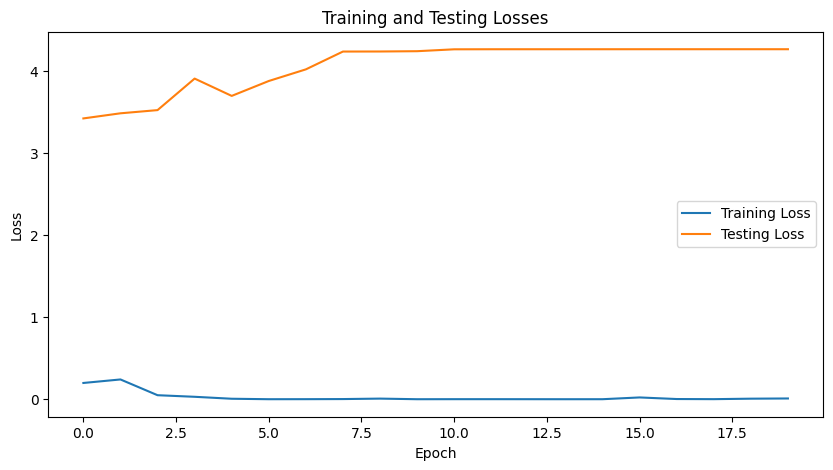

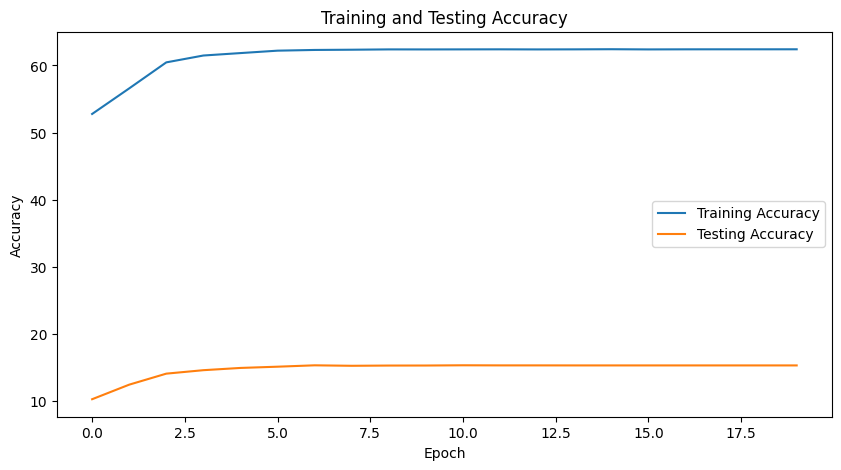

In [20]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot([t/800 for t in train_correct], label='Training Accuracy')
plt.plot([t/200 for t in test_correct], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

In [21]:
device = torch.device(device)   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
            
print(y_true[0:5])            
print(y_pred[0:5])

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


In [22]:
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

    airplane     0.8432    0.9730    0.9034      1000
  automobile     0.8999    0.9890    0.9424      1000
        bird     0.8790    0.9300    0.9038      1000
         cat     0.8541    0.8780    0.8659      1000
        deer     1.0000    0.3380    0.5052      1000
         dog     0.8330    0.9280    0.8780      1000
        frog     0.9309    0.9700    0.9500      1000
       horse     0.8896    0.9670    0.9267      1000
        ship     0.9071    0.9760    0.9403      1000
       truck     0.9472    0.9510    0.9491      1000

    accuracy                         0.8900     10000
   macro avg     0.8984    0.8900    0.8765     10000
weighted avg     0.8984    0.8900    0.8765     10000



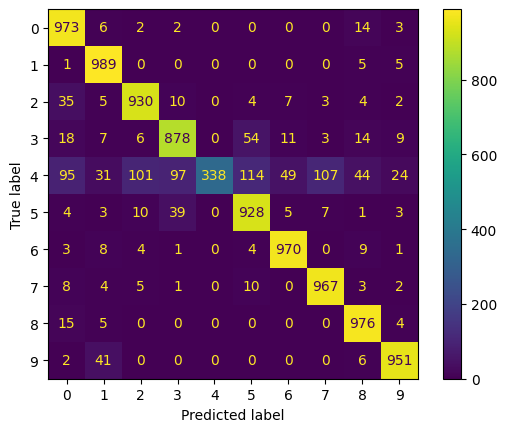

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [24]:
# Save the model state dictionary
torch.save(model.state_dict(), '/kaggle/working/model.pth')

In [25]:
# Define your model architecture
model = MyModel() 
# Load the model state dictionary
model.load_state_dict(torch.load('/kaggle/working/model.pth'))

<All keys matched successfully>